In [13]:
import pandas as pd
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolcastRC.csv")
# Assuming your dataset is loaded into a DataFrame called 'data'
# Convert the 'period_end' column to datetime type
data['period_end'] = pd.to_datetime(data['period_end'])

# Filter data to keep only rows between 6 AM and 6 PM
filtered_data = data[(data['period_end'].dt.hour >= 6) & (data['period_end'].dt.hour < 18)]

filtered_data.to_csv(r"C:\Users\Sasi Kanth\Desktop\SolcastRC_Filtered.csv")


In [15]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolcastRC_Filtered.csv")

# Retain the 'period_end' column (or 'period') for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (you can drop 'period' but retain 'period_end')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
selected_features = ['air_temp', 'clearsky_dhi', 'clearsky_dni', 'dewpoint_temp', 'ghi', 'precipitation_rate', 'relative_humidity']
X_data = data[selected_features]
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Create sequences and labels for LSTM
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 8  # Number of 5-min intervals (e.g., for 2 hours ahead)
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust the timestamps for the sequences (remove the first 'sequence_length' entries)
timestamps = timestamps[sequence_length:]

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))  # Output layer for 'gti' prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)

model.save('RC15min_solar_model_17.h5')
model.save_weights('RC15min_solar_model_17.weights.h5')


Epoch 1/20


c:\Users\Sasi Kanth\anaconda3\envs\rengoku\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3408/3408 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0111 - val_loss: 0.0020
Epoch 2/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/20
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/20
3408/3408 ━━━━━━━━

In [16]:
# Inverse transform the predictions and actual values to get the original scale
predictions = scaler_y.inverse_transform(predictions)
actual_values = scaler_y.inverse_transform(y_test)

# Calculate absolute errors
errors = np.abs(predictions - actual_values)

# Find the indices of the max and min errors
max_error_idx = np.argmax(errors)
min_error_idx = np.argmin(errors)

# Retrieve max and min errors and their corresponding predicted, actual values, and timestamps
max_error = errors[max_error_idx]
min_error = errors[min_error_idx]

max_error_predicted = predictions[max_error_idx][0]
max_error_actual = actual_values[max_error_idx][0]
max_error_time = timestamps_test[max_error_idx]

min_error_predicted = predictions[min_error_idx][0]
min_error_actual = actual_values[min_error_idx][0]
min_error_time = timestamps_test[min_error_idx]

# Print the results
print(f"Maximum Error: {max_error}")
print(f"Predicted Value (Max Error): {max_error_predicted}, Actual Value (Max Error): {max_error_actual}")
print(f"Timestamp (Max Error): {max_error_time}")

print(f"Minimum Error: {min_error}")
print(f"Predicted Value (Min Error): {min_error_predicted}, Actual Value (Min Error): {min_error_actual}")
print(f"Timestamp (Min Error): {min_error_time}")

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

Maximum Error: [570.66638184]
Predicted Value (Max Error): 696.6663818359375, Actual Value (Max Error): 126.0
Timestamp (Max Error): 2024-02-04 12:30:00+04:00
Minimum Error: [0.]
Predicted Value (Min Error): 0.0, Actual Value (Min Error): 0.0
Timestamp (Min Error): 2021-01-19 17:15:00+04:00
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0011
Test MSE: 0.0011662999168038368


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming `scalerx` is used for feature scaling and `scalery` is used for target scaling
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions using scalery
predictions = scaler_y.inverse_transform(predictions)

# Inverse transform the actual values (y_test) using scalery
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, predictions)
print(f"Mean Absolute Error: {mae}")




2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Absolute Error: 24.37571314535772


In [18]:
from sklearn.metrics import r2_score

# Calculate R² Score
r2 = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f"Test R² Score: {r2}")


Test R² Score: 0.9855813414198356


In [19]:
# Inverse transform the true test labels (y_test) to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Avoid division by zero by filtering out zero values in the actual test set
non_zero_indices = y_test_original != 0

# Calculate the errors (difference between actual and predicted values) for non-zero actual values
errors_percentage = np.abs((y_test_original[non_zero_indices] - predictions[non_zero_indices]) / y_test_original[non_zero_indices]) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(errors_percentage)

print(f"Total Error Percentage (MAPE): {mape:.2f}%")


Total Error Percentage (MAPE): 18.91%


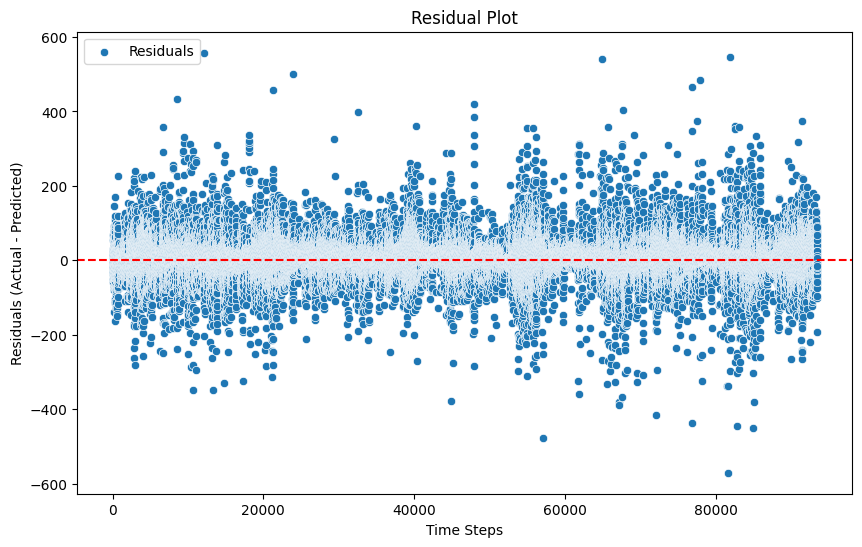

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate residuals
residuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)) - predictions

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(residuals)), y=residuals.flatten(), label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time Steps')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


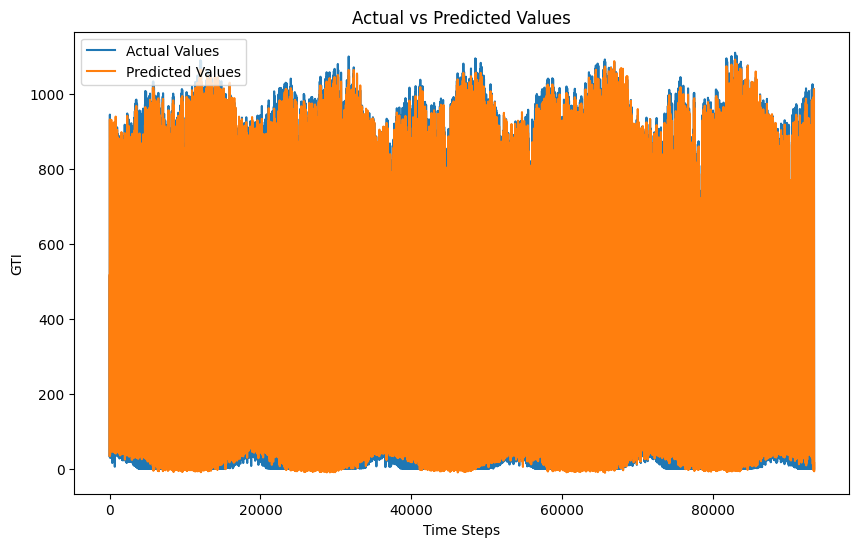

In [21]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('GTI')
plt.legend()
plt.show()


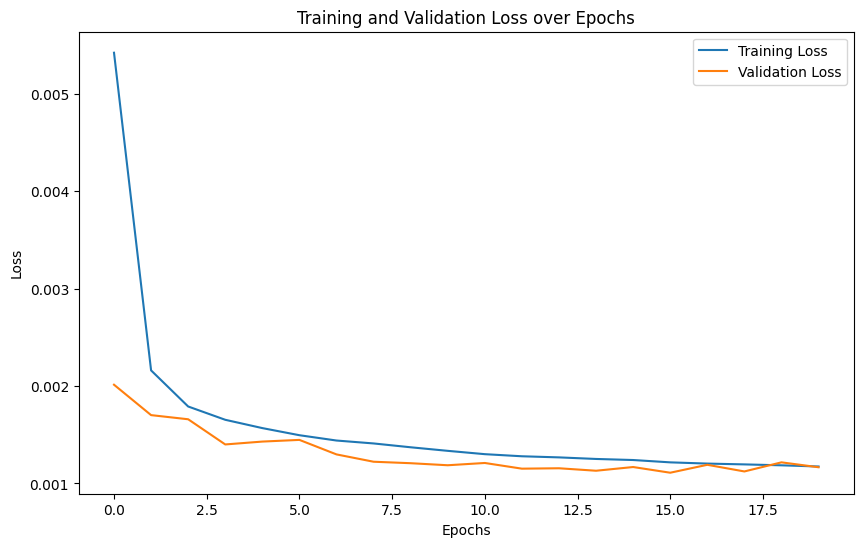

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolcastRC_Filtered.csv")

# Retain the 'period_end' column for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (keep 'period_end', drop 'period')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
selected_features = ['air_temp', 'clearsky_dhi', 'clearsky_dni', 'dewpoint_temp', 'ghi', 'precipitation_rate', 'relative_humidity']
X_data = data[selected_features]
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 24  # Assuming 2 hours (24 * 5-minute intervals)
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust timestamps to remove first 'sequence_length' entries
timestamps = timestamps[sequence_length:]

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Load your saved model
model = load_model(r"C:\Users\Sasi Kanth\Desktop\YayySOLARDATA\RC_solar_model_17_min15.h5")

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions_original_scale = scaler_y.inverse_transform(predictions)

# Inverse transform the true y_test values to their original scale
y_test_original_scale = scaler_y.inverse_transform(y_test)

# Extract the corresponding part of the original dataset for the test split
original_test_data = data.iloc[split + sequence_length:].copy()

# Add the predictions to the original test dataset
original_test_data['predicted_gti'] = predictions_original_scale

# Optionally, add the true values for comparison
original_test_data['true_gti'] = y_test_original_scale

# Save the dataset with the predictions
output_path = r"C:\Users\Sasi Kanth\Desktop\RC_Min15TestDatasetWithPredictions.csv"
original_test_data.to_csv(output_path, index=False)

print(f"Test dataset with predictions saved to: {output_path}")


2921/2921 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Test dataset with predictions saved to: C:\Users\Sasi Kanth\Desktop\RC_Min15TestDatasetWithPredictions.csv
